In [1]:
import os
import requests
import numpy as np
import pandas as pd
import vextract.svg
import vextract.filter
import vextract.convert
import svgpathtools as spt
import matplotlib.pyplot as plt
from pprint import pprint

from pathlib import Path

%matplotlib widget
%load_ext autoreload
%autoreload 2

In [2]:
# We need to download the article file.
# This article is not open access - a subscription is required.

URL = "https://www.nature.com/articles/s41586-020-2801-z.pdf"

if not Path('../data/source_data/s41586-020-2801-z.pdf').exists():
    print('Article file not found.  Attempting to download.')
    response = requests.get(URL)
    try:
        open('../data/source_data/s41586-020-2801-z.pdf', 'wb').write(response.content)
        print('Article successfully downloaded.')
    except OSError:
        print('Failed to download article.')
else:
    print('Article file found.')

Article file found.


In [3]:
# The un-edited paper: Nature volume 586, pages373–377 (2020).
paper_file = '../data/source_data/s41586-020-2801-z.pdf'

# Location to store the svg version of the relevant page.
svg_page_file = '../data/svg_files/CSH_page_3.svg'

# The page number on which the relavant figure is located.
# While it is page 3 of the pdf, this page is labeled as page 375.
page_number = 375

# Convert page 3 of the paper into an svg file.
os.system(f'pdf2svg {paper_file} {svg_page_file} {page_number}')

# Load the svg file into memory.
# The resulting structure is a tuple of two lists.
# The first is a list of the path objects.
# The second is a list of the corresponding attributes.
svg = (
    # Convert color codes to hex for convenience.
    vextract.convert.hexify(
        # Apply transformation matrix that is inluded in svg attributes.
        vextract.convert.apply_tmatrix(
            # load the file in a tuple of paths and attributes.
            spt.svg2paths(svg_page_file))))

In [4]:
# Here is an example of a red 9 T data point:
pprint(svg[0][30000])
pprint(svg[1][30000])

Path(Line(start=(398.47656277000004+104.94531264000001j), end=(399.816407+103.605469j)),
     Line(start=(399.816407+103.605469j), end=(401.160157+104.94531264000001j)),
     Line(start=(401.160157+104.94531264000001j), end=(399.816407+106.28125j)),
     Line(start=(399.816407+106.28125j), end=(398.47656277000004+104.94531264000001j)))
{'d': 'M 0.00045777 -0.00143164 L 1.340302 1.338412 L 2.684052 -0.00143164 L '
      '1.340302 -1.337369 Z M 0.00045777 -0.00143164 ',
 'style': 'fill-rule:evenodd;fill:#ed2224;fill-opacity:1;stroke-width:0.139;stroke-linecap:round;stroke-linejoin:round;stroke:#871719;stroke-opacity:1;stroke-miterlimit:10;',
 'transform': 'matrix(1,0,0,-1,398.476105,104.943881)'}


/tmp/ipykernel_451318/2781709314.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(color_count_series.index, rotation = 90)


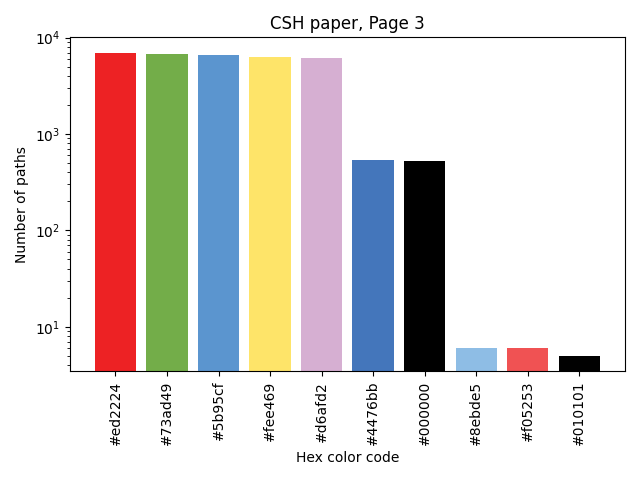

In [5]:
# This is a useful plot for figuring out colors that correspond to
# large numbers of data points.

fig, ax = plt.subplots()
color_count_series = vextract.svg.count_fill_colors(svg)
ax.bar(
    color_count_series.index,
    color_count_series,
    color=color_count_series.index,
    log=True)
ax.set_xticklabels(color_count_series.index, rotation = 90)
ax.set_xlabel('Hex color code')
ax.set_ylabel('Number of paths')
ax.set_title('CSH paper, Page 3')
fig.tight_layout()

In [6]:
# Make an association between colors and magnetic field.

colors = ['#d6afd2',
          '#fee469',
          '#73ad49',
          '#5b95cf',
          '#ed2224']

fields = ['0',
          '1',
          '3',
          '6',
          '9']

legend = dict(zip(fields, colors))
legend

{'0': '#d6afd2',
 '1': '#fee469',
 '3': '#73ad49',
 '6': '#5b95cf',
 '9': '#ed2224'}

In [7]:
# Selecting just the paths of the correct color 
# and assigning them to the corresponding fields.

dict_of_svgs = {}
for field, color in legend.items():
    dict_of_svgs[field] = vextract.filter.by_fill(svg, color)

In [8]:
# mag_dict is a dictionary where the keys are the applied field and
# the values are the corresponding dataframes.

mag_dict = {}
for field in legend:
    paths, attributes = dict_of_svgs[field]
    centers = []
    for path in paths:
        centers.append(vextract.svg.path_centroid(path))
    df = pd.DataFrame()
    df['x'] = [center[0] for center in centers]
    df['y'] = [center[1] for center in centers]
    mag_dict[field] = df

In [9]:
# Here is an example of what our data looks like so far.
mag_dict['0']

,x,y
0,483.116211,79.774414
1,482.004883,74.278320
2,481.958008,74.140625
3,481.958008,74.972656
4,481.913086,74.833008
...,...,...
6130,284.311524,205.343750
6131,284.264649,205.296875
6132,284.218750,205.574218
6133,284.218750,205.527344


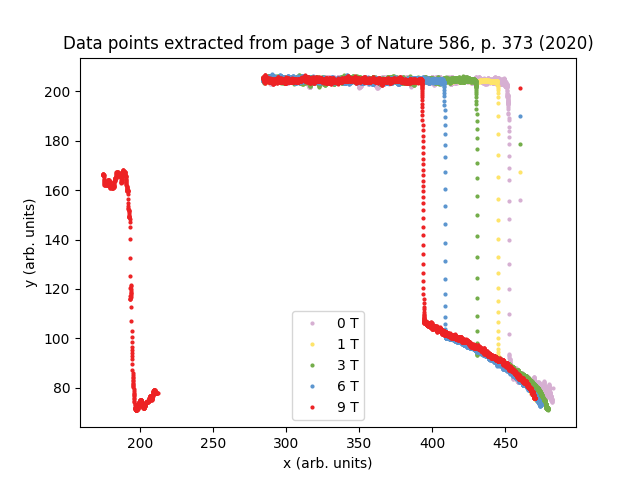

In [10]:
# Here is a plot showing all of the extracted data.
# The x and y axes are in arbitrary units of the svg file.
# In addition, we see some points from the legend and from
# The 189 GPa data in Fig. 2a.
fig, ax = plt.subplots()
for field, color in legend.items():
    df = mag_dict[field]
    ax.plot(df.x, df.y, 'o', color=color, label=f'{field} T', markersize=2)
ax.set_xlabel('x (arb. units)')
ax.set_ylabel('y (arb. units)')
ax.set_title('Data points extracted from page 3 of Nature 586, p. 373 (2020)')
ax.legend()

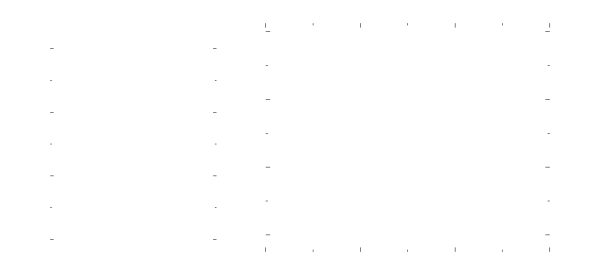

In [11]:
# In Fig. 1a, the tick marks are drawn as rectangles.
# For Fig. 2b, they are drawn as lines.  Looking at the figure in
# the paper, we see that there should be 7 tick marks on both the 
# x and y axes of Fig. 2b.
length_to_search_for = 7

paths, attributes = svg

tick_marks_svg = (
    vextract
    .filter
    .by_stroke(
        vextract
        .filter
        .by_length(
            svg,
            length_to_search_for),
        # Tick marks are drawn in black stroke color.
        '#000000'
    )
)

vextract.svg.display_svg(tick_marks_svg)

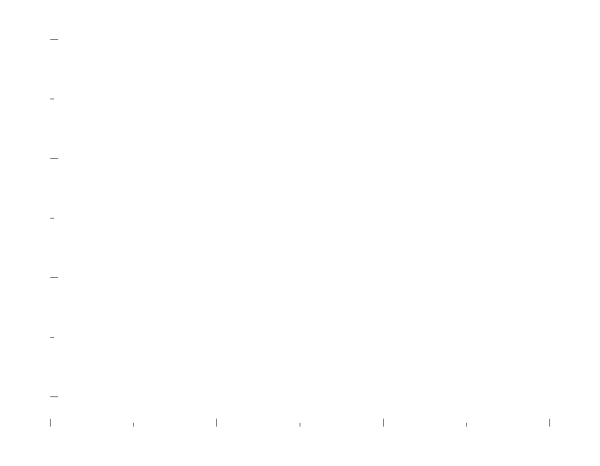

In [12]:
# With a little trial and error, we can figure out which
# of the length 7 paths correspond to the x and tick marks
# of Fig. 2b.

paths, attributes = tick_marks_svg

# Here I selected some different combinations until finding
# the one that matched the x and y tick marks for Fig. 2b.
paths_to_plot = [0,2]

filtered_paths = []
filtered_attributes = []
for i in range(len(paths)):
    if i in paths_to_plot:
        filtered_paths.append(paths[i])
        filtered_attributes.append(attributes[i])
    
filtered_svg = (filtered_paths, filtered_attributes)

vextract.svg.display_svg(filtered_svg)

In [13]:
# These are the paths corresponding to the x and y tick marks
# that we figured out in the pane above.
x_ticks_path = paths[0]
y_ticks_path = paths[2]

# In the svg Path objects, the x-coordinates are stored in the real part
# and the y-coordinates in the imaginary.
# Here we are just pulling out the x and y coordinates of the x and y
# tick marks respectively.
xtics  = [path[0].real for path in x_ticks_path]
ytics  = [path[0].imag for path in y_ticks_path]

# Store the extremal tick marks.
xmin = xtics[0]
xmax = xtics[3]
ymin = ytics[0]
ymax = ytics[3]

In [14]:
# Apply scaling to put data points in same units as axis labels.
for field in mag_dict:
    df = mag_dict[field]
    df['Temp'] = (df['x']
                  .apply(
                      lambda x: (vextract
                                 .svg
                                 .transform_coord(
                                     xmin,
                                     xmax,
                                     300.0,
                                     225.0,
                                     x))))
    
    df['R'] = (df['y']
               .apply(
                   lambda y: (vextract
                              .svg
                              .transform_coord(
                                  ymin,
                                  ymax,
                                  1.2,
                                  0,
                                  y))))

In [15]:
# Here is what our data looks like at present.
display(mag_dict['0'])

,x,y,Temp,R
0,483.116211,79.774414,298.529560,1.042690
1,482.004883,74.278320,298.118718,1.088127
2,481.958008,74.140625,298.101389,1.089265
3,481.958008,74.972656,298.101389,1.082387
4,481.913086,74.833008,298.084782,1.083541
...,...,...,...,...
6130,284.311524,205.343750,225.034297,0.004586
6131,284.264649,205.296875,225.016968,0.004973
6132,284.218750,205.574218,225.000000,0.002680
6133,284.218750,205.527344,225.000000,0.003068


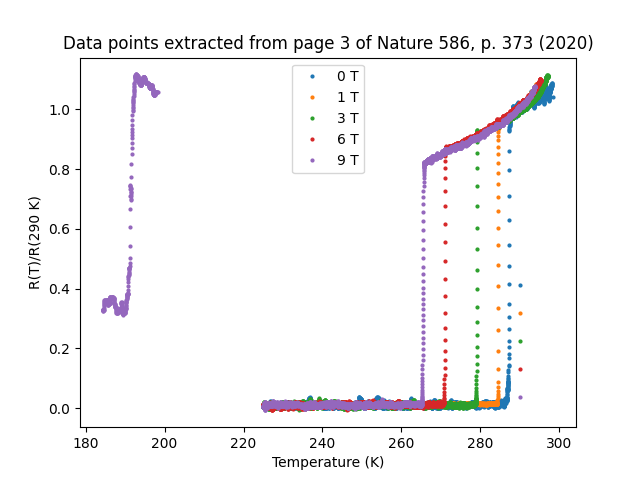

In [16]:
# Here is a plot showing all of the extracted data.
# The x and y axes are in arbitrary units of the svg file.
# In addition, we see some points from the legend and from Fig. 1b.
fig, ax = plt.subplots()
for field in mag_dict:
    df = mag_dict[field]
    ax.plot(df.Temp, df.R, 'o', label=f'{field} T', markersize=2)
ax.set_xlabel('Temperature (K)')
ax.set_ylabel('R(T)/R(290 K)')
ax.set_title('Data points extracted from page 3 of Nature 586, p. 373 (2020)')
ax.legend()

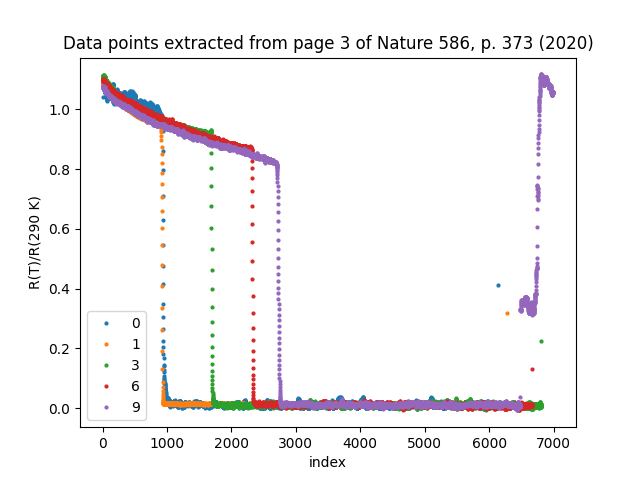

In [17]:
# In order to trim out the points from the legend and from Fig. 2a
# it is helpful to make a plot showing the order in which the points appear.
fig, ax = plt.subplots()
for field in mag_dict:
    df = mag_dict[field]
    ax.plot(df.index, df.R, 'o', label=field, markersize=2)
ax.set_xlabel('index')
ax.set_ylabel('R(T)/R(290 K)')
ax.set_title('Data points extracted from page 3 of Nature 586, p. 373 (2020)')
ax.legend()

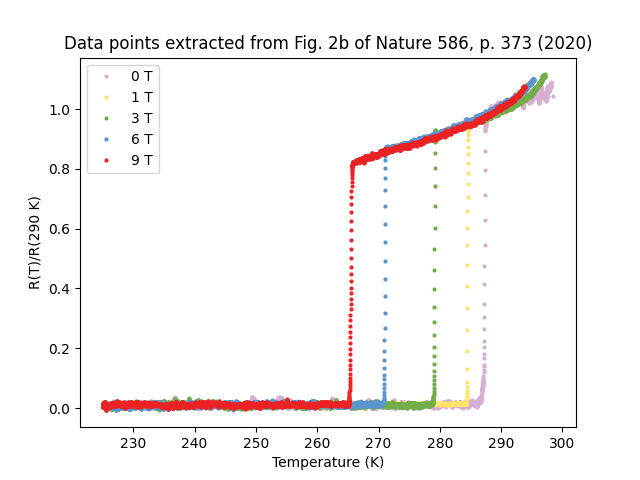

In [18]:
# Using the interactive feature of matplotlib in jupyter-lab on the 
# plot above, we can zoom in to find the range of row numbers (index)
# that correspond to each measurement.
# We'll store the data in a dictionary with the pressure in GPa as key.

# The legend point is plotted last, so here we drop the last point.
mag_dict['0'] = mag_dict['0'][:-1].copy()
mag_dict['1'] = mag_dict['1'][:-1].copy()
mag_dict['3'] = mag_dict['3'][:-1].copy()
mag_dict['6'] = mag_dict['6'][:-1].copy()
# The 9 T data is plotted using the same color as some data in Fig. 2a.
mag_dict['9'] = mag_dict['9'][0:6484].copy()

fig, ax = plt.subplots()
for field, color in legend.items():
    df = mag_dict[field]
    ax.plot(df.Temp, df.R, 'o', color=color, label=f'{field} T', markersize=2)
ax.set_xlabel('Temperature (K)')
ax.set_ylabel('R(T)/R(290 K)')
ax.set_title('Data points extracted from Fig. 2b of Nature 586, p. 373 (2020)')
ax.legend()

In [19]:
# Export the data to csv.

save_folder = '../data/extracted_data/CSH-Fig2b'

for field in mag_dict:
    df = mag_dict[field]
    df.to_csv(f'{save_folder}/0{field}_T.csv', index=False)